In [1]:
import os

import pickle
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as func
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
with open('data/bibtex/train.pickle', "rb") as f:
    temp = pickle.load(f)
    data_x = np.array([instance['feats'] for instance in temp])
    data_y = np.array([instance['types'] for instance in temp])

with open('data/bibtex/test.pickle', "rb") as f:
    temp = pickle.load(f)
    test_x = np.array([instance['feats'] for instance in temp])
    test_y = np.array([instance['types'] for instance in temp])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_x = torch.FloatTensor(data_x).to(device)
data_y = torch.FloatTensor(data_y).to(device)
test_x = torch.FloatTensor(test_x).to(device)
test_y = torch.FloatTensor(test_y).to(device)


In [2]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1836, 150)
        self.layer2 = nn.Linear(150, 150)
        self.out_l = nn.Linear(150, 159, bias=False)

    def forward(self, x, only_feature_extraction=False):
        out = func.relu(self.layer1(x))
        out = func.relu(self.layer2(out))
        if not only_feature_extraction:
            out = self.out_l(out)
            out = torch.sigmoid(out)
        return out


def f1_map(y, pred, threshold=None):
    if threshold is None:
        threshold = [0.05, 0.10, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75]
    else:
        threshold = [0.5]
    best_f1 = 0
    for t in threshold:
        local_pred = pred > t
        local_f1 = f1_score(y.data.cpu().numpy(), local_pred.data.cpu().numpy(), average='samples')
        if local_f1 > best_f1:
            best_f1 = local_f1
    precision = np.mean(metrics.average_precision_score(
        y.data.cpu().numpy(), pred.data.cpu().numpy(), average=None
    ))

    return best_f1, precision

In [3]:

class EnergyNetwork(nn.Module):
    def __init__(self, weights_last_layer_mlp=150, feature_dim=150, label_dim=159,
                 num_pairwise=16, non_linearity=nn.Softplus()):
        super().__init__()

        self.non_linearity = non_linearity

        self.B = torch.nn.Parameter(torch.transpose(-weights_last_layer_mlp, 0, 1))

        # Label energy terms, C1/c2  in equation 5 of SPEN paper
        self.C1 = torch.nn.Parameter(torch.empty(label_dim, num_pairwise))
        torch.nn.init.normal_(self.C1, mean=0, std=np.sqrt(2.0 / label_dim))

        self.c2 = torch.nn.Parameter(torch.empty(num_pairwise, 1))
        torch.nn.init.normal_(self.c2, mean=0, std=np.sqrt(2.0 / num_pairwise))

    def forward(self, x, y):
        # Local energy
        e_local = torch.mm(x, self.B)
        # element-wise product
        e_local = torch.mul(y, e_local)
        e_local = torch.sum(e_local, dim=1)
        # e_local = e_local.view(e_local.size()[0], 1)

        # Label energy
        e_label = self.non_linearity(torch.mm(y, self.C1))
        e_label = torch.mm(e_label, self.c2)
        e_global = torch.add(e_label.view(-1), e_local)

        return e_global


class SPEN:
    def __init__(self, feature_net, energy_net, inf_net, label_dim=159, args=None):
        super().__init__()
        self.feature_extractor = feature_net
        self.feature_extractor.eval()
        self.energy_net = energy_net
        self.inf_net = inf_net
        self.hidden_size = 150

        self.cost_infnet = nn.Sequential(nn.Linear(2 * label_dim, label_dim), nn.Sigmoid()).to(device)

    def _compute_energy(self, inputs, targets):
        f_x = self.feature_extractor(inputs, only_feature_extraction=True)

        # Energy ground truth
        gt_energy = self.energy_net(f_x, targets)

        # inference network
        inf_labels = self.inf_net(inputs)
        inf_energy = self.energy_net(f_x, inf_labels)

        temp = torch.cat((inf_labels, targets), dim=1)
        cost_inf_y = self.cost_infnet(temp)
        cost_inf_energy = self.energy_net(f_x, cost_inf_y)

        return inf_labels, inf_energy, cost_inf_y, cost_inf_energy, gt_energy

    def forward(self, inputs, targets):
        inf_labels, inf_energy, cost_inf_y, cost_inf_energy, gt_energy = self._compute_energy(inputs, targets)

        delta = torch.sum((cost_inf_y - targets)**2, dim=1)

        local_ce = nn.BCELoss()(inf_labels, targets)

        # Max-margin Loss for theta
        hinge_loss_1 = delta - cost_inf_energy + gt_energy
        cost_loss_1 = torch.mean(torch.relu(hinge_loss_1))

        hinge_loss_2 = - inf_energy + gt_energy
        cost_loss_2 = torch.mean(torch.relu(hinge_loss_2))

        energy_loss = cost_loss_1 + cost_loss_2

        # loss for inf and cost inf
        inf_loss = torch.mean(-delta + inf_energy + cost_inf_energy) + 0.2 * local_ce
        return inf_labels, cost_inf_y, energy_loss, inf_loss

    def pred(self, x):
        with torch.no_grad():
            y_pred = self.inf_net(x)
        return y_pred

In [4]:
import time
# Stage 1
# pre-training feature net or load pretrained
dataset = 'bibtex'
base_model = MLP().to(device)
if not os.path.isfile('../%s_basej.pt' % dataset):
    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-3, weight_decay=0)

    for epoch in range(20):
        inds = np.random.permutation(list(range(len(data_x))))
        start_time = time.time()
        for i in range(0, 4880, 80):
            idx = inds[i:i + 80]
            data = data_x[idx]
            label = data_y[idx]
            logits = base_model(data)

            loss = criterion(logits, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        end_time = time.time()
        print('Epoch', epoch)
        print('Training Speed: %d examples/sec' % int(4880 / (end_time - start_time)))
        with torch.no_grad():
            pred_test = base_model(test_x)

        f1, mAP = f1_map(test_y, pred_test)
        print(f1, mAP)
        print()
    torch.save(base_model.state_dict(), '../%s_basej.pt' % dataset)
else:
    base_model.load_state_dict(torch.load('../%s_basej.pt' % dataset))

with torch.no_grad():
    pred_test = base_model(test_x)

f1, mAP = f1_map(test_y, pred_test)
print("current base model", f1, mAP)
base_f1 = [f1]
base_mAP = [mAP]

current base model 0.38942661119320504 0.29234121405754354


init inference model 0.031241373933631852 0.017993678289269274
K 1
0 Inf loss: 274.6659, theta loss: 0.0000
inference net f1:0.031969, mAP:0.020527
base net f1:0.38982, mAP:0.020527

1 Inf loss: 153.0855, theta loss: 0.4028
inference net f1:0.031609, mAP:0.020745
base net f1:0.39076, mAP:0.020745

2 Inf loss: 119.8135, theta loss: 0.0000
inference net f1:0.031878, mAP:0.02073
base net f1:0.39004, mAP:0.02073

3 Inf loss: 115.2451, theta loss: 0.5532
inference net f1:0.032614, mAP:0.020591
base net f1:0.39343, mAP:0.020591

4 Inf loss: 110.2295, theta loss: 0.0000
inference net f1:0.032707, mAP:0.020797
base net f1:0.39332, mAP:0.020797

5 Inf loss: 95.3306, theta loss: 0.0000
inference net f1:0.027097, mAP:0.021642
base net f1:0.39476, mAP:0.021642

6 Inf loss: 78.0276, theta loss: 0.3712
inference net f1:0.027914, mAP:0.021672
base net f1:0.396, mAP:0.021672

7 Inf loss: 69.4081, theta loss: 0.0000
inference net f1:0.037878, mAP:0.022442
base net f1:0.3969, mAP:0.022442

8 Inf loss: 5

base net f1:0.37851, mAP:0.25652

72 Inf loss: -7.7385, theta loss: 0.3022
inference net f1:0.35822, mAP:0.25608
base net f1:0.37861, mAP:0.25608

73 Inf loss: -9.7038, theta loss: 0.8665
inference net f1:0.36002, mAP:0.25304
base net f1:0.37838, mAP:0.25304

74 Inf loss: -11.3549, theta loss: 0.8583
inference net f1:0.36088, mAP:0.25526
base net f1:0.3782, mAP:0.25526

75 Inf loss: -6.8243, theta loss: 0.4046
inference net f1:0.35835, mAP:0.25625
base net f1:0.37845, mAP:0.25625

76 Inf loss: -10.2032, theta loss: 0.5317
inference net f1:0.35811, mAP:0.25533
base net f1:0.37798, mAP:0.25533

77 Inf loss: -4.9716, theta loss: 0.3961
inference net f1:0.3658, mAP:0.25608
base net f1:0.37767, mAP:0.25608

78 Inf loss: -11.4619, theta loss: 0.2744
inference net f1:0.35913, mAP:0.25623
base net f1:0.37772, mAP:0.25623

79 Inf loss: -10.9029, theta loss: 0.2735
inference net f1:0.3611, mAP:0.26012
base net f1:0.3774, mAP:0.26012

80 Inf loss: -8.4852, theta loss: 0.6564
inference net f1:0.36

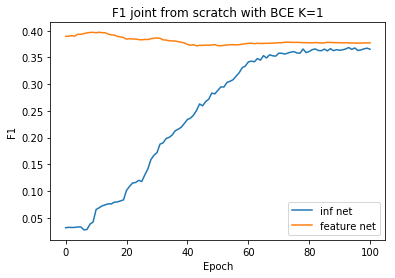

In [5]:
# Stage 2, train the inference net
inf_net = MLP().to(device)
# inf_net.load_state_dict(base_model.state_dict())

with torch.no_grad():
    pred_test = inf_net(test_x)

f1, mAP = f1_map(test_y, pred_test)

f1s = [f1]
maps = [mAP]
print("init inference model", f1, mAP)

energy_net = EnergyNetwork(base_model.out_l.weight).to(device)

spen = SPEN(base_model, energy_net, inf_net,)

optim_inf = torch.optim.Adam(list(inf_net.parameters()) + list(spen.cost_infnet.parameters()), lr=0.001, weight_decay=0)
optim_energy = torch.optim.Adam(list(energy_net.parameters()) + list(base_model.parameters()), lr=1e-5, weight_decay=0)

epochs = 100
sch_inf = torch.optim.lr_scheduler.CosineAnnealingLR(optim_inf, epochs)
sch_energy = torch.optim.lr_scheduler.CosineAnnealingLR(optim_energy, epochs)

K = 1
print("K", K)
for epoch in range(epochs):
    inds = np.random.permutation(list(range(len(data_x))))
    for i in range(0, 4880, 32):
        l = inds[i:i+32]
        data = data_x[l]
        label = data_y[l]

        for i in range(K):
            optim_inf.zero_grad()
            preds, _, _, inf_loss = spen.forward(data, label)
            inf_loss.backward()
            optim_inf.step()

        optim_energy.zero_grad()
        preds, _, e_loss, _ = spen.forward(data, label)

        e_loss.backward()
        optim_energy.step()
    print(epoch, 'Inf loss: {:.4f}, theta loss: {:.4f}'.format(inf_loss, e_loss))

    # sch_inf.step()
    # sch_energy.step()
    pred_test = spen.pred(test_x)
    best_f1, mAP = f1_map(test_y, pred_test)
    print('inference net f1:{:.5}, mAP:{:.5}'.format(float(best_f1), float(mAP)))
    f1s.append(best_f1)
    maps.append(mAP)

    pred_test = base_model(test_x)
    best_f1, map = f1_map(test_y, pred_test)
    print('base net f1:{:.5}, mAP:{:.5}'.format(float(best_f1), float(mAP)))
    base_f1.append(best_f1)
    base_mAP.append(mAP)
    print()

plt.plot(np.arange(epochs + 1), f1s, label='inf net')
plt.plot(np.arange(epochs + 1), base_f1, label='feature net')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.title('F1 joint from scratch with BCE K=%d' % K)
plt.show()
plt.close()


init inference model 0.38942661119320504 0.29234121405754354
K 1
0 Inf loss: 108.8287, theta loss: 0.0000
inference net f1:0.10267, mAP:0.26141
base net f1:0.3384, mAP:0.26141

1 Inf loss: 97.0277, theta loss: 0.0000
inference net f1:0.11504, mAP:0.25372
base net f1:0.30879, mAP:0.25372

2 Inf loss: 49.3190, theta loss: 0.0000
inference net f1:0.145, mAP:0.26402
base net f1:0.30311, mAP:0.26402

3 Inf loss: 48.4413, theta loss: 0.0000
inference net f1:0.15522, mAP:0.26462
base net f1:0.32497, mAP:0.26462

4 Inf loss: 44.6423, theta loss: 0.0000
inference net f1:0.16473, mAP:0.26035
base net f1:0.29729, mAP:0.26035

5 Inf loss: 31.6699, theta loss: 0.0000
inference net f1:0.18514, mAP:0.26432
base net f1:0.30708, mAP:0.26432

6 Inf loss: 19.6644, theta loss: 0.1709
inference net f1:0.19824, mAP:0.2695
base net f1:0.28772, mAP:0.2695

7 Inf loss: 21.8766, theta loss: 0.1239
inference net f1:0.19958, mAP:0.27448
base net f1:0.30753, mAP:0.27448

8 Inf loss: 23.0548, theta loss: 0.0000
inf

base net f1:0.30395, mAP:0.29366

73 Inf loss: -0.7127, theta loss: 0.1460
inference net f1:0.40285, mAP:0.29685
base net f1:0.28769, mAP:0.29685

74 Inf loss: -2.6350, theta loss: 0.0007
inference net f1:0.40545, mAP:0.29659
base net f1:0.29029, mAP:0.29659

75 Inf loss: -7.1788, theta loss: 0.0047
inference net f1:0.401, mAP:0.29429
base net f1:0.29028, mAP:0.29429

76 Inf loss: -6.4419, theta loss: 0.0003
inference net f1:0.41368, mAP:0.29617
base net f1:0.28909, mAP:0.29617

77 Inf loss: -10.6065, theta loss: 0.0058
inference net f1:0.40029, mAP:0.29488
base net f1:0.28905, mAP:0.29488

78 Inf loss: -7.5486, theta loss: 0.0028
inference net f1:0.40904, mAP:0.2967
base net f1:0.2907, mAP:0.2967

79 Inf loss: -7.6176, theta loss: 0.0020
inference net f1:0.4024, mAP:0.29488
base net f1:0.27733, mAP:0.29488

80 Inf loss: -9.2610, theta loss: 0.0000
inference net f1:0.40069, mAP:0.29459
base net f1:0.29211, mAP:0.29459

81 Inf loss: -4.5693, theta loss: 0.0000
inference net f1:0.40386, 

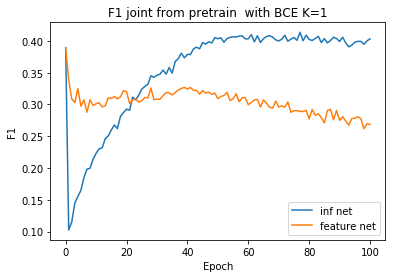

In [9]:
base_model.load_state_dict(torch.load('../%s_basej.pt' % dataset))
with torch.no_grad():
    pred_test = base_model(test_x)

f1, mAP = f1_map(test_y, pred_test)
base_f1 = [f1]
base_mAP = [mAP]

# # Stage 2, train the inference net
inf_net = MLP().to(device)
inf_net.load_state_dict(base_model.state_dict())
with torch.no_grad():
    pred_test = inf_net(test_x)

f1, mAP = f1_map(test_y, pred_test)

f1s = [f1]
maps = [mAP]

print("init inference model", f1, mAP)

energy_net = EnergyNetwork(base_model.out_l.weight).to(device)

spen = SPEN(base_model, energy_net, inf_net,)

optim_inf = torch.optim.Adam(list(inf_net.parameters()) + list(spen.cost_infnet.parameters()), lr=0.001, weight_decay=0)
optim_energy = torch.optim.Adam(list(energy_net.parameters()) + list(base_model.parameters()), lr=1e-3, weight_decay=0)

epochs = 100
sch_inf = torch.optim.lr_scheduler.CosineAnnealingLR(optim_inf, epochs)
sch_energy = torch.optim.lr_scheduler.CosineAnnealingLR(optim_energy, epochs)

K = 1
print("K", K)
for epoch in range(epochs):
    inds = np.random.permutation(list(range(len(data_x))))
    for i in range(0, 4880, 32):
        l = inds[i:i+32]
        data = data_x[l]
        label = data_y[l]

        for i in range(K):
            optim_inf.zero_grad()
            preds, _, _, inf_loss = spen.forward(data, label)
            inf_loss.backward()
            optim_inf.step()

        optim_energy.zero_grad()
        preds, _, e_loss, _ = spen.forward(data, label)

        e_loss.backward()
        optim_energy.step()
    print(epoch, 'Inf loss: {:.4f}, theta loss: {:.4f}'.format(inf_loss, e_loss))

    # sch_inf.step()
    # sch_energy.step()
    pred_test = spen.pred(test_x)
    best_f1, mAP = f1_map(test_y, pred_test)
    print('inference net f1:{:.5}, mAP:{:.5}'.format(float(best_f1), float(mAP)))
    f1s.append(best_f1)
    maps.append(mAP)

    pred_test = base_model(test_x)
    best_f1, map = f1_map(test_y, pred_test)
    print('base net f1:{:.5}, mAP:{:.5}'.format(float(best_f1), float(mAP)))
    base_f1.append(best_f1)
    base_mAP.append(mAP)
    print()

plt.plot(np.arange(epochs + 1), f1s, label='inf net')
plt.plot(np.arange(epochs + 1), base_f1, label='feature net')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.title('F1 joint from pretrain  with BCE K=%d' % K)
plt.show()
plt.close()


In [12]:
class SPEN:
    def __init__(self, feature_net, energy_net, inf_net, label_dim=159, args=None):
        super().__init__()
        self.feature_extractor = feature_net
        # self.feature_extractor.eval()
        self.energy_net = energy_net
        self.inf_net = inf_net
        self.hidden_size = 150

        self.cost_infnet = nn.Sequential(nn.Linear(2 * label_dim, label_dim), nn.Softmax(dim=1)).to(device)
        # self.local2label = nn.Linear(self.hidden_size, self.num_tags)
        # self.inf2label = nn.Linear(self.hidden_size, self.num_tags)

    def _compute_energy(self, inputs, targets):
        f_x = self.feature_extractor(inputs, only_feature_extraction=True)

        # Energy ground truth
        gt_energy = self.energy_net(f_x, targets)

        # inference network
        inf_labels = self.inf_net(inputs)
        inf_energy = self.energy_net(f_x, inf_labels)

        temp = torch.cat((inf_labels, targets), dim=1)
        cost_inf_y = self.cost_infnet(temp)
        cost_inf_energy = self.energy_net(f_x, cost_inf_y)

        return inf_labels, inf_energy, cost_inf_y, cost_inf_energy, gt_energy

    def forward(self, inputs, targets):
        inf_labels, inf_energy, cost_inf_y, cost_inf_energy, gt_energy = self._compute_energy(inputs, targets)

        delta = torch.sum((cost_inf_y - targets)**2, dim=1)

        local_ce = nn.BCELoss()(inf_labels, targets)

        # Max-margin Loss for theta
        hinge_loss_1 = delta - cost_inf_energy + gt_energy
        cost_loss_1 = torch.mean(torch.relu(hinge_loss_1))

        hinge_loss_2 = - inf_energy + gt_energy
        cost_loss_2 = torch.mean(torch.relu(hinge_loss_2))

        energy_loss = cost_loss_1 + cost_loss_2

        # loss for inf and cost inf
        inf_loss = torch.mean(-delta + inf_energy + cost_inf_energy) + 0.2 * local_ce
        return inf_labels, cost_inf_y, energy_loss, inf_loss

    def pred(self, x):
        with torch.no_grad():
            y_pred = self.inf_net(x)
        return y_pred

init inference model 0.38942661119320504 0.29234121405754354
K 1
0 Inf loss: -3.2817, theta loss: 0.0988
inference net f1:0.38943, mAP:0.30734
base net f1:0.39063, mAP:0.30734

1 Inf loss: 0.7563, theta loss: 0.1568
inference net f1:0.39051, mAP:0.30636
base net f1:0.38989, mAP:0.30636

2 Inf loss: 0.9588, theta loss: 0.0410
inference net f1:0.38868, mAP:0.30383
base net f1:0.38199, mAP:0.30383

3 Inf loss: -1.3124, theta loss: 0.1971
inference net f1:0.39573, mAP:0.30455
base net f1:0.38885, mAP:0.30455

4 Inf loss: -3.4019, theta loss: 0.0869
inference net f1:0.39579, mAP:0.30359
base net f1:0.38667, mAP:0.30359

5 Inf loss: -6.1883, theta loss: 0.3413
inference net f1:0.39782, mAP:0.30305
base net f1:0.38489, mAP:0.30305

6 Inf loss: -2.4021, theta loss: 0.1519
inference net f1:0.39684, mAP:0.30215
base net f1:0.38058, mAP:0.30215

7 Inf loss: -5.6076, theta loss: 0.0701
inference net f1:0.39267, mAP:0.30321
base net f1:0.37445, mAP:0.30321

8 Inf loss: -8.7261, theta loss: 0.2132
i

72 Inf loss: -11.4908, theta loss: 0.0215
inference net f1:0.39585, mAP:0.28605
base net f1:0.33863, mAP:0.28605

73 Inf loss: -12.2832, theta loss: 0.0652
inference net f1:0.39622, mAP:0.28343
base net f1:0.34565, mAP:0.28343

74 Inf loss: -15.6254, theta loss: 0.0894
inference net f1:0.39944, mAP:0.28817
base net f1:0.34334, mAP:0.28817

75 Inf loss: -11.7800, theta loss: 0.0230
inference net f1:0.39258, mAP:0.28626
base net f1:0.34533, mAP:0.28626

76 Inf loss: -9.6244, theta loss: 0.0005
inference net f1:0.39448, mAP:0.28563
base net f1:0.34406, mAP:0.28563

77 Inf loss: -13.5375, theta loss: 0.0823
inference net f1:0.39338, mAP:0.28287
base net f1:0.34193, mAP:0.28287

78 Inf loss: -12.2436, theta loss: 0.0154
inference net f1:0.39296, mAP:0.28664
base net f1:0.33908, mAP:0.28664

79 Inf loss: -13.7837, theta loss: 0.1197
inference net f1:0.39894, mAP:0.28637
base net f1:0.34216, mAP:0.28637

80 Inf loss: -17.8001, theta loss: 0.0486
inference net f1:0.4022, mAP:0.28455
base net f

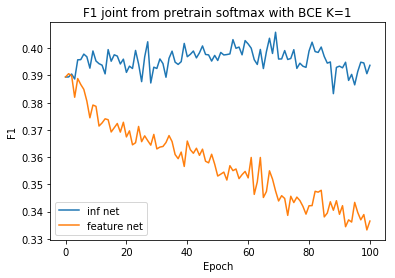

In [13]:
base_model.load_state_dict(torch.load('../%s_basej.pt' % dataset))
with torch.no_grad():
    pred_test = base_model(test_x)

f1, mAP = f1_map(test_y, pred_test)
base_f1 = [f1]
base_mAP = [mAP]
# Stage 2, train the inference net

inf_net = MLP().to(device)
inf_net.load_state_dict(base_model.state_dict())

with torch.no_grad():
    pred_test = inf_net(test_x)

f1, mAP = f1_map(test_y, pred_test)

f1s = [f1]
maps = [mAP]
print("init inference model", f1, mAP)

energy_net = EnergyNetwork(base_model.out_l.weight).to(device)

spen = SPEN(base_model, energy_net, inf_net,)

optim_inf = torch.optim.Adam(list(inf_net.parameters()) + list(spen.cost_infnet.parameters()), lr=0.001, weight_decay=0)
optim_energy = torch.optim.Adam(list(energy_net.parameters()) + list(base_model.parameters()), lr=5e-4, weight_decay=0)

epochs = 100
sch_inf = torch.optim.lr_scheduler.CosineAnnealingLR(optim_inf, epochs)
sch_energy = torch.optim.lr_scheduler.CosineAnnealingLR(optim_energy, epochs)

K = 1
print("K", K)
for epoch in range(epochs):
    inds = np.random.permutation(list(range(len(data_x))))
    for i in range(0, 4880, 32):
        l = inds[i:i+32]
        data = data_x[l]
        label = data_y[l]

        for i in range(K):
            optim_inf.zero_grad()
            preds, _, _, inf_loss = spen.forward(data, label)
            inf_loss.backward()
            optim_inf.step()

        optim_energy.zero_grad()
        preds, _, e_loss, _ = spen.forward(data, label)

        e_loss.backward()
        optim_energy.step()
    print(epoch, 'Inf loss: {:.4f}, theta loss: {:.4f}'.format(inf_loss, e_loss))

    # sch_inf.step()
    # sch_energy.step()
    pred_test = spen.pred(test_x)
    best_f1, mAP = f1_map(test_y, pred_test)
    print('inference net f1:{:.5}, mAP:{:.5}'.format(float(best_f1), float(mAP)))
    f1s.append(best_f1)
    maps.append(mAP)

    pred_test = base_model(test_x)
    best_f1, map = f1_map(test_y, pred_test)
    print('base net f1:{:.5}, mAP:{:.5}'.format(float(best_f1), float(mAP)))
    base_f1.append(best_f1)
    base_mAP.append(mAP)
    print()

plt.plot(np.arange(epochs + 1), f1s, label='inf net')
plt.plot(np.arange(epochs + 1), base_f1, label='feature net')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.title('F1 joint from pretrain softmax with BCE K=%d' % K)
plt.show()
plt.close()
